In [13]:
import os
import nibabel as nib
import numpy as np
import gzip
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
import random
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import nibabel as nib
import os
from tensorflow import keras
import matplotlib.pyplot as plt

In [4]:
# apply windowing to the image data
def apply_window(image, wl, ww):
    min_val = wl - (ww / 2)
    max_val = wl + (ww / 2)
    windowed_img = np.clip(image, min_val, max_val)
    windowed_img = (windowed_img - min_val) / (max_val - min_val)  # Normalize between 0 and 1
    return windowed_img

In [14]:
ct_directory = '/kaggle/input/brain-ct/label_192/images'  
gt_directory = '/kaggle/input/brain-ct/label_192/ground truths'  
output_directory = '/kaggle/working/output_directory'  

os.makedirs(output_directory, exist_ok=True)

In [15]:
gt_directory = '/kaggle/input/brain-ct/label_192/ground truths'

# Initialize a counter for hemorrhage scans
hemorrhage_count = 0
total_scans = 0

for filename in os.listdir(gt_directory):
    if filename.endswith('.nii'):  #
        total_scans += 1
        gt_path = os.path.join(gt_directory, filename)
        gt_image = nib.load(gt_path).get_fdata()  

        # Check if there are any non-zero values indicating hemorrhage
        if np.any(gt_image > 0):  
            hemorrhage_count += 1

print(f"Total CT Scans: {total_scans}")
print(f"CT Scans with Hemorrhage: {hemorrhage_count}")
print(f"Percentage of scans with hemorrhage: {(hemorrhage_count / total_scans) * 100:.2f}%")


Total CT Scans: 192
CT Scans with Hemorrhage: 192
Percentage of scans with hemorrhage: 100.00%


In [18]:
for filename in os.listdir(ct_directory):
    if filename.endswith('.nii'):
        try:
            print(f"Processing {filename}...")

            ct_image_path = os.path.join(ct_directory, filename)
            img = nib.load(ct_image_path)
            img_data = img.get_fdata()  

            subdural_window = apply_window(img_data, wl=50, ww=130)  
            bone_window = apply_window(img_data, wl=600, ww=2800)   

            # Stack the two windows into a 4D array (height, width, depth, channels)
            stacked_input = np.stack([subdural_window, bone_window], axis=-1)

            # Load corresponding ground truth mask
            gt_image_path = os.path.join(gt_directory, filename)  
            if not os.path.exists(gt_image_path):
                print(f"Ground truth file not found: {gt_image_path}")
                continue

            gt_img = nib.load(gt_image_path)
            gt_img_data = gt_img.get_fdata()  

            # Save the stacked input and ground truth mask in the output directory
            stacked_input_nifti = nib.Nifti1Image(stacked_input, img.affine)  
            gt_nifti = nib.Nifti1Image(gt_img_data, gt_img.affine)

            # Define output file paths
            output_stacked_path = os.path.join(output_directory, filename.replace('.nii', '_stacked.nii'))
            output_gt_path = os.path.join(output_directory, filename.replace('.nii', '_gt.nii'))

            # Save the new NIfTI files to uncompressed files first
            nib.save(stacked_input_nifti, output_stacked_path)
            nib.save(gt_nifti, output_gt_path)

            # Compress the saved NIfTI files to .nii.gz format
            with open(output_stacked_path, 'rb') as f_in:
                with gzip.open(output_stacked_path + '.gz', 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)  

            with open(output_gt_path, 'rb') as f_in:
                with gzip.open(output_gt_path + '.gz', 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)  

            # Delete the uncompressed files to save space
            os.remove(output_stacked_path)
            os.remove(output_gt_path)

            print(f"Preprocessed and saved: {filename}")

        except Exception as e:
            print(f"Error processing {filename}: {e}")

print("Preprocessing and saving completed.")

Processing ID_30d19531_ID_cf607a5cd7.nii...
Preprocessed and saved: ID_30d19531_ID_cf607a5cd7.nii
Processing ID_4e227c9c_ID_d8607fa88e.nii...
Preprocessed and saved: ID_4e227c9c_ID_d8607fa88e.nii
Processing ID_f335b6db_ID_d180629430.nii...
Preprocessed and saved: ID_f335b6db_ID_d180629430.nii
Processing ID_87385103_ID_684afaed55.nii...
Preprocessed and saved: ID_87385103_ID_684afaed55.nii
Processing ID_87e60d98_ID_0c2d2758ae.nii...
Preprocessed and saved: ID_87e60d98_ID_0c2d2758ae.nii
Processing ID_9e0eaeeb_ID_be5b5b11eb.nii...
Preprocessed and saved: ID_9e0eaeeb_ID_be5b5b11eb.nii
Processing ID_c488fbef_ID_ae4af6dd21.nii...
Preprocessed and saved: ID_c488fbef_ID_ae4af6dd21.nii
Processing ID_3343ddf2_ID_fddff2e9c1.nii...
Preprocessed and saved: ID_3343ddf2_ID_fddff2e9c1.nii
Processing ID_16ed917a_ID_145f184354.nii...
Preprocessed and saved: ID_16ed917a_ID_145f184354.nii
Processing ID_196704db_ID_4eb6296376.nii...
Preprocessed and saved: ID_196704db_ID_4eb6296376.nii
Processing ID_268b38

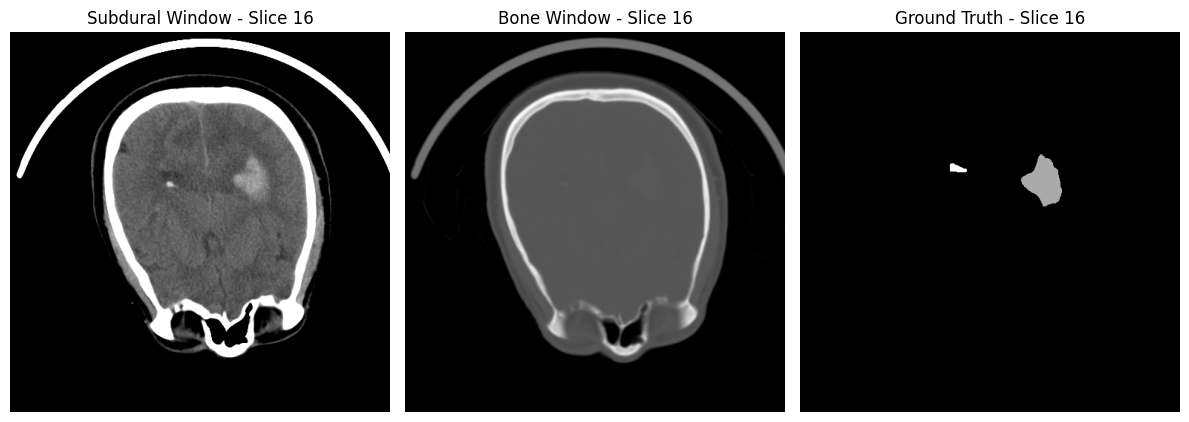

In [7]:
def visualize_preprocessed_and_gt(preprocessed_path, gt_path, slice_num=None):
    
    stacked_img = nib.load(preprocessed_path)
    stacked_img_data = stacked_img.get_fdata() 

    # Load the ground truth NIfTI file
    gt_img = nib.load(gt_path)
    gt_img_data = gt_img.get_fdata()  

    
    if slice_num is None:
        slice_num = stacked_img_data.shape[2] // 2  

    # Plotting
    plt.figure(figsize=(12, 6))

    # Subdural Window Channel
    plt.subplot(1, 3, 1)
    plt.imshow(stacked_img_data[:, :, slice_num, 0].T, cmap='gray')  
    plt.title(f"Subdural Window - Slice {slice_num}")
    plt.axis('off')

    # Bone Window Channel
    plt.subplot(1, 3, 2)
    plt.imshow(stacked_img_data[:, :, slice_num, 1].T, cmap='gray')  
    plt.title(f"Bone Window - Slice {slice_num}")
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 3, 3)
    plt.imshow(gt_img_data[:, :, slice_num].T, cmap='gray')  
    plt.title(f"Ground Truth - Slice {slice_num}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

preprocessed_file_path = '/kaggle/working/output_directory/ID_811a274b_ID_fa1c9402fb_stacked.nii.gz'  
gt_file_path = '/kaggle/working/output_directory/ID_811a274b_ID_fa1c9402fb_gt.nii.gz'  

visualize_preprocessed_and_gt(preprocessed_file_path, gt_file_path)


In [9]:
# Define the folders for saving the voxel patches
brain_voxels_dir = 'brain_voxels'
groundtruth_voxels_dir = 'groundtruth_voxels'

os.makedirs(brain_voxels_dir, exist_ok=True)
os.makedirs(groundtruth_voxels_dir, exist_ok=True)

print("Directories created: brain_voxels and groundtruth_voxels")

Directories created: brain_voxels and groundtruth_voxels


In [9]:
# Define the directory where the output files are stored
output_directory = '/kaggle/working/output_directory'

# Initialize a set to keep track of unique shapes
unique_shapes = set()

# Iterate over each NIfTI file in the directory
for filename in os.listdir(output_directory):
    if filename.endswith('.nii') or filename.endswith('_stacked.nii.gz'):  # Support both compressed and uncompressed formats
        file_path = os.path.join(output_directory, filename)
        
        nii_file = nib.load(file_path)
        
        img_shape = nii_file.shape
        
        unique_shapes.add(img_shape)

# Print each unique shape one by one
print("Unique shapes across all files:")
for shape in unique_shapes:
    print(shape)


Unique shapes across all files:
(512, 512, 39, 2)
(512, 512, 30, 2)
(512, 512, 32, 2)
(512, 512, 34, 2)
(512, 512, 36, 2)
(512, 512, 38, 2)
(512, 512, 60, 2)
(512, 512, 29, 2)
(512, 512, 40, 2)
(512, 512, 42, 2)
(512, 512, 33, 2)
(512, 512, 31, 2)
(512, 512, 44, 2)
(512, 512, 24, 2)
(512, 512, 35, 2)
(512, 512, 46, 2)
(512, 512, 37, 2)
(512, 512, 28, 2)
(512, 512, 48, 2)


In [ ]:
def pad_to_patch_size(img, patch_size=(53, 53, 53), channels=2):
  
    if img.ndim == 4:  # For CT images (4D)
        padded_img = np.pad(
            img,
            ((0, max(0, patch_size[0] - img.shape[0])),
             (0, max(0, patch_size[1] - img.shape[1])),
             (0, max(0, patch_size[2] - img.shape[2])),
             (0, max(0, channels - img.shape[-1]))),
            mode='constant', constant_values=0
        )
    elif img.ndim == 3:  # For Ground Truth (3D)
        padded_img = np.pad(
            img,
            ((0, max(0, patch_size[0] - img.shape[0])),
             (0, max(0, patch_size[1] - img.shape[1])),
             (0, max(0, patch_size[2] - img.shape[2]))),
            mode='constant', constant_values=0
        )
    else:
        raise ValueError("Input image must be 3D or 4D.")
    return padded_img

In [ ]:
def extract_voxels(ct_img_data, gt_img_data, original_filename, patch_size=(53, 53, 53)):
    patch_index = 1
    ct_img_data = pad_to_patch_size(ct_img_data, patch_size=patch_size, channels=2)
    gt_img_data = pad_to_patch_size(gt_img_data, patch_size=patch_size, channels=1)

    for x in range(0, ct_img_data.shape[0] - patch_size[0] + 1, patch_size[0]):
        for y in range(0, ct_img_data.shape[1] - patch_size[1] + 1, patch_size[1]):
            for z in range(0, ct_img_data.shape[2] - patch_size[2] + 1, patch_size[2]):
                x_patch = ct_img_data[x:x + patch_size[0], y:y + patch_size[1], z:z + patch_size[2], :]
                y_patch = gt_img_data[x:x + patch_size[0], y:y + patch_size[1], z:z + patch_size[2]]

                brain_voxel_filename = f"{original_filename.replace('.nii.gz', '')}_stacked_voxel{patch_index:02d}.npz"
                groundtruth_voxel_filename = f"{original_filename.replace('.nii.gz', '')}_gt_voxel{patch_index:02d}.npz"
                
                np.savez_compressed(os.path.join(brain_voxels_dir, brain_voxel_filename), x_patch)
                np.savez_compressed(os.path.join(groundtruth_voxels_dir, groundtruth_voxel_filename), y_patch)
                patch_index += 1

    print(f"Extracted and saved {patch_index-1} patches for {original_filename} in compressed format.")

In [20]:
output_directory = '/kaggle/working/output_directory'

# Get all files that end with '_stacked.nii.gz'
all_files = [f for f in os.listdir(output_directory) if f.endswith('_stacked.nii.gz')]

for sample_file in all_files:
    try:
        print(f"Processing {sample_file}...")

        # Load the stacked CT image and corresponding ground truth mask
        ct_image_path = os.path.join(output_directory, sample_file)
        img = nib.load(ct_image_path)
        ct_img_data = img.get_fdata()

        # Load corresponding ground truth
        gt_filename = sample_file.replace('_stacked', '_gt')
        gt_image_path = os.path.join(output_directory, gt_filename)
        gt_img = nib.load(gt_image_path)
        gt_img_data = gt_img.get_fdata()

        # Extract and save voxels with unique names
        extract_voxels(ct_img_data, gt_img_data, original_filename=sample_file)

        # Verify the dimensions of saved patches
        saved_files = [f for f in os.listdir(brain_voxels_dir) if f.startswith(sample_file.replace('.nii.gz', ''))]
        print(f"Number of patches saved for {sample_file}: {len(saved_files)}")

    except Exception as e:
        print(f"Error processing {sample_file}: {e}")

print("Voxel extraction for all files completed.")


Processing ID_b92014da_ID_a9310805a0_stacked.nii.gz...
Extracted and saved 81 patches for ID_b92014da_ID_a9310805a0_stacked.nii.gz in compressed format.
Number of patches saved for ID_b92014da_ID_a9310805a0_stacked.nii.gz: 81
Processing ID_fcbe7eda_ID_5726e1c630_stacked.nii.gz...
Extracted and saved 81 patches for ID_fcbe7eda_ID_5726e1c630_stacked.nii.gz in compressed format.
Number of patches saved for ID_fcbe7eda_ID_5726e1c630_stacked.nii.gz: 81
Processing ID_98450f26_ID_8d66ffdc94_stacked.nii.gz...
Extracted and saved 81 patches for ID_98450f26_ID_8d66ffdc94_stacked.nii.gz in compressed format.
Number of patches saved for ID_98450f26_ID_8d66ffdc94_stacked.nii.gz: 81
Processing ID_63862d24_ID_24f0f2ff02_stacked.nii.gz...
Extracted and saved 81 patches for ID_63862d24_ID_24f0f2ff02_stacked.nii.gz in compressed format.
Number of patches saved for ID_63862d24_ID_24f0f2ff02_stacked.nii.gz: 81
Processing ID_f335b6db_ID_d180629430_stacked.nii.gz...
Extracted and saved 81 patches for ID_f33

In [11]:
# Define the directories for voxel files
brain_voxels_dir = '/kaggle/working/brain_voxels'
groundtruth_voxels_dir = '/kaggle/working/groundtruth_voxels'

# Get the list of all .npz files in both directories
brain_voxels_files = [f for f in os.listdir(brain_voxels_dir) if f.endswith('.npz')]
groundtruth_voxels_files = [f for f in os.listdir(groundtruth_voxels_dir) if f.endswith('.npz')]

# Count the number of files in each directory
print(f"Number of files in brain_voxels directory: {len(brain_voxels_files)}")
print(f"Number of files in groundtruth_voxels directory: {len(groundtruth_voxels_files)}")

# Check if the counts match
if len(brain_voxels_files) == len(groundtruth_voxels_files):
    print("CT and ground truth voxel files match in count.")
else:
    print("Mismatch in the number of CT and ground truth voxel files.")

Number of files in brain_voxels directory: 15552
Number of files in groundtruth_voxels directory: 15552
CT and ground truth voxel files match in count.


In [7]:
from tensorflow.keras.saving import register_keras_serializable
@register_keras_serializable(package='Custom', name='create_pathway')
def create_pathway(input_tensor, downsampling_factor=1):
    x = input_tensor
    
    if downsampling_factor > 1:
        x = layers.AveragePooling3D(pool_size=downsampling_factor)(x)
    
    # First two convolutional layers
    for _ in range(2):
        x = layers.Conv3D(30, kernel_size=5, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
    
    # Next three convolutional layers
    for _ in range(3):
        x = layers.Conv3D(40, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
    
    # Residual connection after 5th layer
    residual = x
    
    # Last two convolutional layers
    for i in range(2):
        x = layers.Conv3D(50, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        if i == 0:  # Residual connection after 6th layer
            residual = layers.Conv3D(50, kernel_size=1, padding='same')(residual)
            x = layers.Add()([x, residual])
    
    return x

def DeepMedic(input_shape=(53, 53, 53, 2), num_classes=2):
    inputs = keras.Input(shape=input_shape)
    
    # Normal pathway
    normal_path = create_pathway(inputs)
    
    # Subsampled pathways
    subsampled_path_1 = create_pathway(inputs, downsampling_factor=2)
    subsampled_path_2 = create_pathway(inputs, downsampling_factor=4)
    subsampled_path_3 = create_pathway(inputs, downsampling_factor=8)
    
    # Upsample subsampled pathways to match the normal path size
    upsampled_1 = layers.UpSampling3D(size=2)(subsampled_path_1)
    upsampled_2 = layers.UpSampling3D(size=4)(subsampled_path_2)
    upsampled_3 = layers.UpSampling3D(size=8)(subsampled_path_3)
    
    # Center crop all paths to match size
    def crop_center(tensor, target_size):
        current_size = tensor.shape[1]
        diff = current_size - target_size
        if diff % 2 != 0:
            crop_start = diff // 2
            crop_end = diff - crop_start
        else:
            crop_start = crop_end = diff // 2
        return layers.Cropping3D(((crop_start, crop_end), 
                                 (crop_start, crop_end), 
                                 (crop_start, crop_end)))(tensor)
    
    # Crop all paths to match the smallest size
    min_size = min(normal_path.shape[1],
                  upsampled_1.shape[1],
                  upsampled_2.shape[1],
                  upsampled_3.shape[1])
                  
    normal_path = crop_center(normal_path, min_size)
    upsampled_1 = crop_center(upsampled_1, min_size)
    upsampled_2 = crop_center(upsampled_2, min_size)
    upsampled_3 = crop_center(upsampled_3, min_size)
    
    # Concatenate all pathways
    concatenated = layers.Concatenate()([normal_path, upsampled_1, upsampled_2, upsampled_3])
    
    # Fully connected layers
    x = layers.Conv3D(250, kernel_size=1, activation='relu')(concatenated)
    x = layers.Conv3D(250, kernel_size=1, activation='relu')(x)
    
    # Output layer with same spatial dimensions as input
    outputs = layers.Conv3D(num_classes, kernel_size=1, activation='sigmoid')(x)
    
    # Ensure output has same spatial dimensions as input
    if outputs.shape[1] != input_shape[0]:
        diff = input_shape[0] - outputs.shape[1]
        pad_size = diff // 2
        pad_extra = diff % 2
        outputs = layers.ZeroPadding3D(padding=((pad_size, pad_size + pad_extra),
                                               (pad_size, pad_size + pad_extra),
                                               (pad_size, pad_size + pad_extra)))(outputs)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the model and show summary
model = DeepMedic(input_shape=(53, 53, 53, 2), num_classes=2)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 53, 53, 53, 2)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling3d_3       │ (None, 26, 26, 26, 2)  │              0 │ input_layer_1[0][0]    │
│ (AveragePooling3D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling3d_4       │ (None, 13, 13, 13, 2)  │              0 │ input_layer_1[0][0]    │
│ (AveragePooling3D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling3d_5       │ (None, 6, 6, 6, 2)     │              0 │ input_layer_1[0][0]    │
│ (AveragePooling3D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_43 (Conv3D)        │ (None, 26, 26, 26, 30) │          7,530 │ average_pooling3d_3[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_51 (Conv3D)        │ (None, 13, 13, 13, 30) │          7,530 │ average_pooling3d_4[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_59 (Conv3D)        │ (None, 6, 6, 6, 30)    │          7,530 │ average_pooling3d_5[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_35 (Conv3D)        │ (None, 53, 53, 53, 30) │          7,530 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, 26, 26, 26, 30) │            120 │ conv3d_43[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_42    │ (None, 13, 13, 13, 30) │            120 │ conv3d_51[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_49    │ (None, 6, 6, 6, 30)    │            120 │ conv3d_59[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 53, 53, 53, 30) │            120 │ conv3d_35[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_35 (ReLU)           │ (None, 26, 26, 26, 30) │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_42 (ReLU)           │ (None, 13, 13, 13, 30) │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_49 (ReLU)           │ (None, 6, 6, 6, 30)    │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_28 (ReLU)      

 Total params: 1,568,502 (5.98 MB)

 Trainable params: 1,566,262 (5.97 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [14]:
@keras.utils.register_keras_serializable()
def loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
        
        # Clip predictions to prevent log(0)
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0)
        
    )
            
    return loss

In [8]:
@keras.utils.register_keras_serializable()
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Flatten the tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Compute intersection
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    
    # Compute dice coefficient
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

In [7]:
import keras
import numpy as np
import os
import random

class VoxelDataGenerator(keras.utils.Sequence):
    def __init__(self, brain_voxels_dir, groundtruth_voxels_dir, 
                 batch_size=2, patch_size=(53, 53, 53), 
                 num_classes=2, shuffle=True, augment=True):
        self.brain_voxels_dir = brain_voxels_dir
        self.groundtruth_voxels_dir = groundtruth_voxels_dir
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.augment = augment
        
        # List of files
        self.brain_voxel_files = [f for f in os.listdir(brain_voxels_dir) if f.endswith('.npz')]
        self.groundtruth_voxels_files = [f.replace('_stacked_voxel', '_gt_voxel') 
                                         for f in self.brain_voxel_files]
        
        # Shuffle if required
        self.on_epoch_end()

    def __len__(self):
        """Number of batches per epoch."""
        return int(np.floor(len(self.brain_voxel_files) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Select batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Prepare batch data
        batch_x = []
        batch_y = []
        
        for i in batch_indices:
            # Load brain voxel data
            brain_voxel_data = np.load(os.path.join(
                self.brain_voxels_dir, 
                self.brain_voxel_files[i]
            ))['arr_0']
            
            # Load ground truth data
            groundtruth_voxel_data = np.load(os.path.join(
                self.groundtruth_voxels_dir, 
                self.groundtruth_voxels_files[i]
            ))['arr_0']
            
            # Augment if required
            if self.augment:
                brain_voxel_data, groundtruth_voxel_data = self._augment_data(
                    brain_voxel_data, groundtruth_voxel_data
                )
            
            # Convert to categorical
            groundtruth_onehot = keras.utils.to_categorical(
                groundtruth_voxel_data, 
                num_classes=self.num_classes
            )
            
            batch_x.append(brain_voxel_data)
            batch_y.append(groundtruth_onehot)
        
        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        """Shuffle indices after each epoch"""
        self.indices = np.arange(len(self.brain_voxel_files))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _augment_data(self, brain_voxel, gt_voxel):
        """Simple data augmentation"""
        # Random flipping
        if np.random.random() > 0.5:
            brain_voxel = np.flip(brain_voxel, axis=0)
            gt_voxel = np.flip(gt_voxel, axis=0)
        
        if np.random.random() > 0.5:
            brain_voxel = np.flip(brain_voxel, axis=1)
            gt_voxel = np.flip(gt_voxel, axis=1)
        
        return brain_voxel, gt_voxel

In [17]:
# Define directories
brain_voxels_dir = '/kaggle/working/brain_voxels'
groundtruth_voxels_dir = '/kaggle/working/groundtruth_voxels'

# Split files into training and validation
all_brain_voxel_files = [f for f in os.listdir(brain_voxels_dir) if f.endswith('.npz')]
train_files, val_files = train_test_split(all_brain_voxel_files, test_size=0.2, random_state=42)

In [3]:
def train_model():

    # Create generators with augmentation
    train_generator = VoxelDataGenerator(
        brain_voxels_dir=brain_voxels_dir, 
        groundtruth_voxels_dir=groundtruth_voxels_dir,
        batch_size=4,
        patch_size=(53, 53, 53),
        num_classes=2,
        augment=True
    )

    val_generator = VoxelDataGenerator(
        brain_voxels_dir=brain_voxels_dir, 
        groundtruth_voxels_dir=groundtruth_voxels_dir,
        batch_size=2,
        patch_size=(53, 53, 53),
        num_classes=2,
        augment=False
    )

    # Create and compile model
    model = DeepMedic(input_shape=(53, 53, 53, 2), num_classes=2)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
        loss=loss_fn,
        metrics=['accuracy', dice_coefficient]
    )

    # Add callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            'best_model.weights.h5',  # Save weights only
            monitor='val_dice_coefficient', 
            mode='max', 
            save_best_only=True,
            save_weights_only=True,  # Save only the weights
            verbose=1, 
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_dice_coefficient', 
            factor=0.5, 
            patience=2, 
            verbose=1, 
            min_lr=1e-7
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=5, 
            restore_best_weights=True
        )
    ]

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        verbose=1,
        callbacks=callbacks
    )
    
    # Save the final best weights explicitly
    model.save_weights('final_model.weights.h5')
    
    print("Training completed")
    return model, history

# Call the training function
model, history = train_model()



Epoch 1/8
3888/3888 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7690 - dice_coefficient: 0.5017 - loss: 0.0016
Epoch 1: val_dice_coefficient improved from -inf to 0.69757, saving model to best_model.weights.h5
3888/3888 ━━━━━━━━━━━━━━━━━━━━ 5658s 1s/step - accuracy: 0.7691 - dice_coefficient: 0.5017 - loss: 0.0016 - val_accuracy: 0.8700 - val_dice_coefficient: 0.6976 - val_loss: 0.0015 - learning_rate: 1.0000e-04
Epoch 2/8
3888/3888 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8647 - dice_coefficient: 0.6811 - loss: 0.0015
Epoch 2: val_dice_coefficient improved from 0.69757 to 0.71109, saving model to best_model.weights.h5
3888/3888 ━━━━━━━━━━━━━━━━━━━━ 5600s 1s/step - accuracy: 0.8647 - dice_coefficient: 0.6811 - loss: 0.0015 - val_accuracy: 0.8873 - val_dice_coefficient: 0.7111 - val_loss: 0.0015 - learning_rate: 1.0000e-04
Epoch 3/8
3888/3888 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8678 - dice_coefficient: 0.6863 - loss: 0.0015
Epoch 3: val_dice_coefficient improved from 0

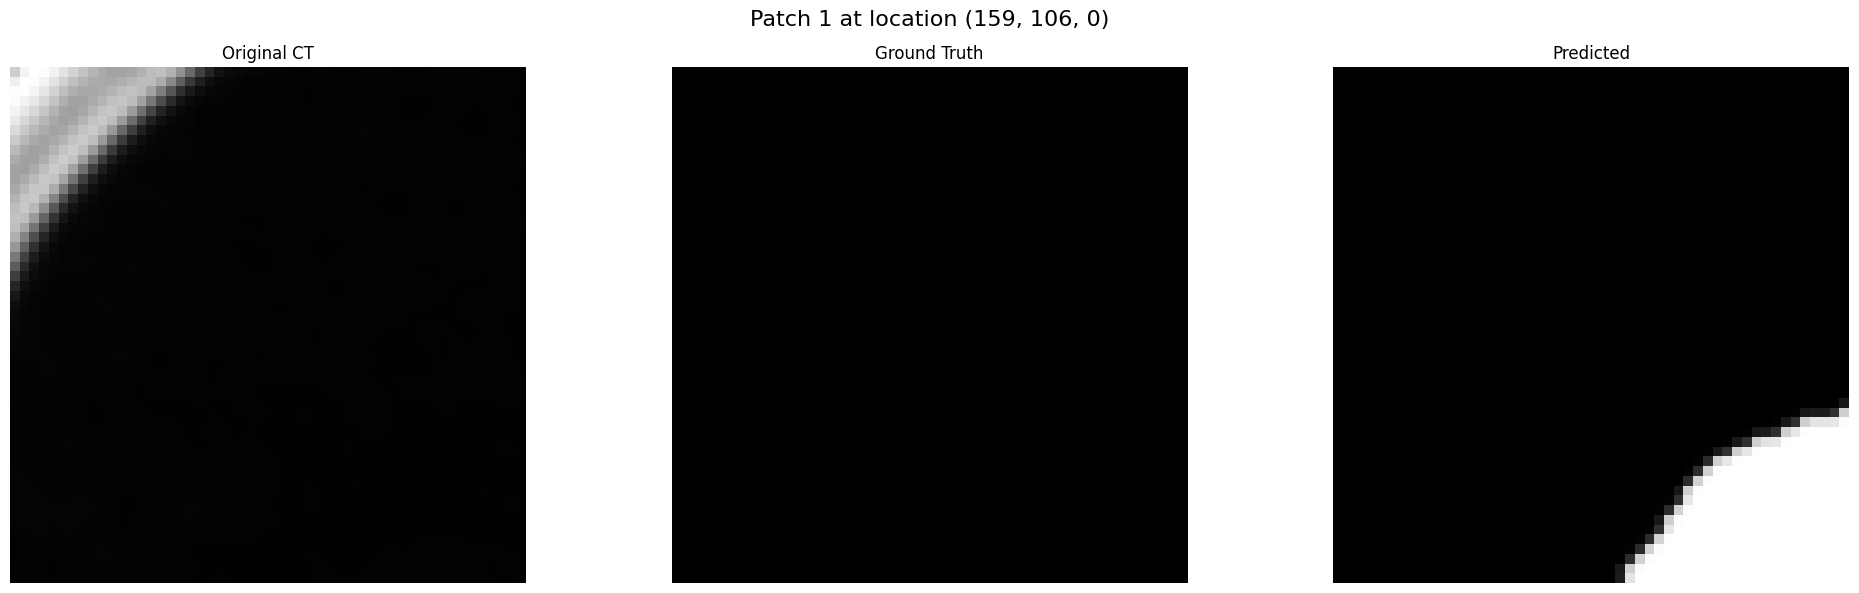

Patch 1 shape - CT: (53, 53, 32), GT: (53, 53, 32)


Patch 2 shape - CT: (53, 53, 32), GT: (53, 53, 32)


Patch 3 shape - CT: (53, 53, 32), GT: (53, 53, 32)


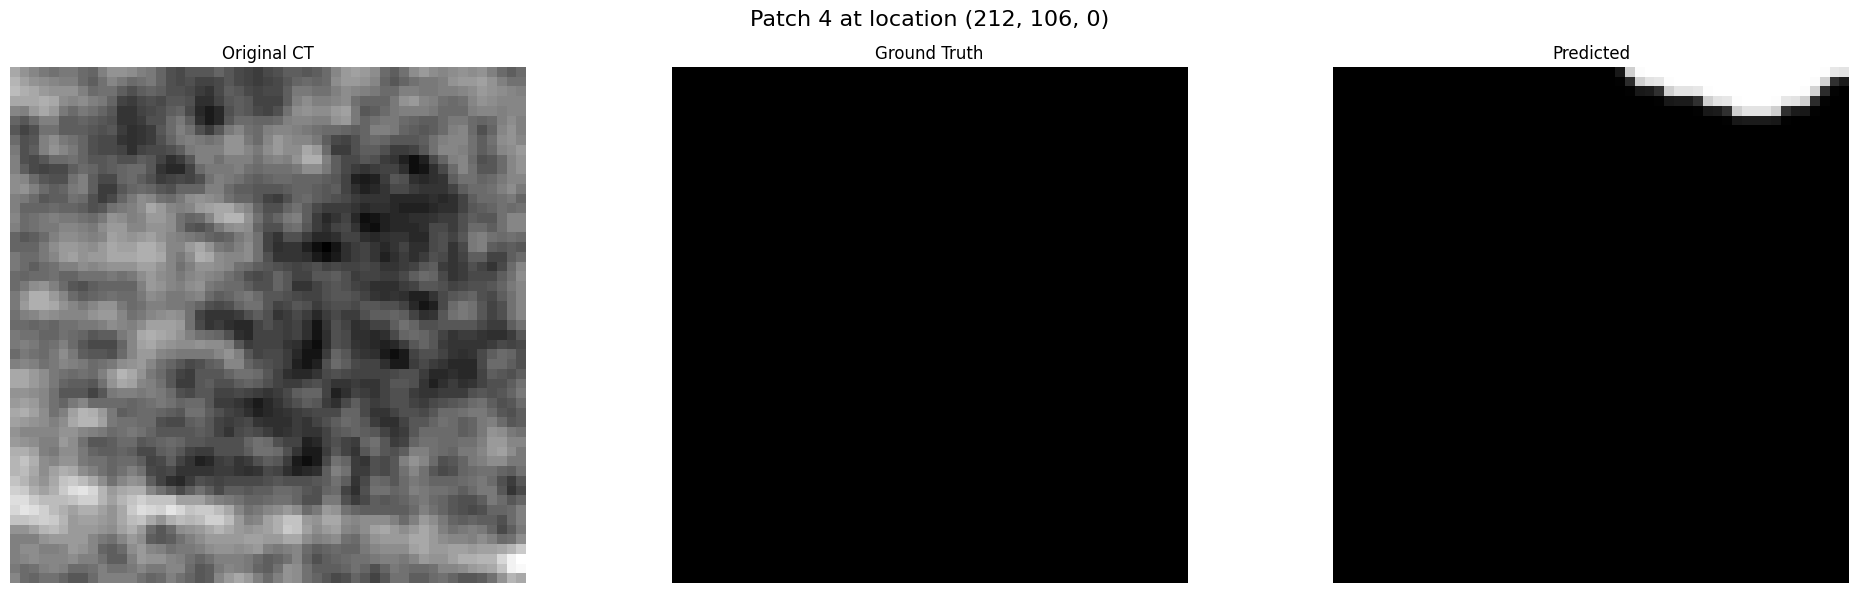

Patch 4 shape - CT: (53, 53, 32), GT: (53, 53, 32)


Patch 5 shape - CT: (53, 53, 32), GT: (53, 53, 32)


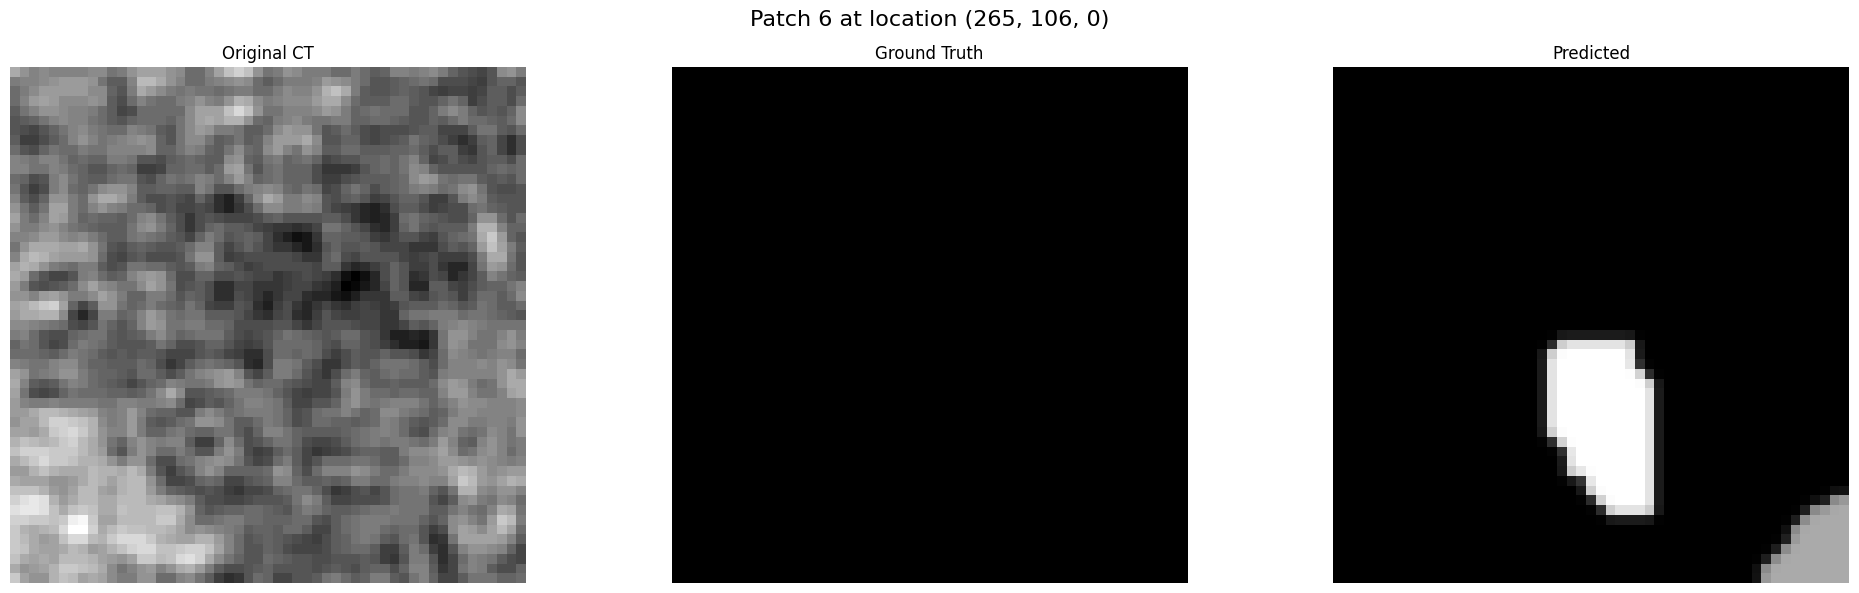

Patch 6 shape - CT: (53, 53, 32), GT: (53, 53, 32)


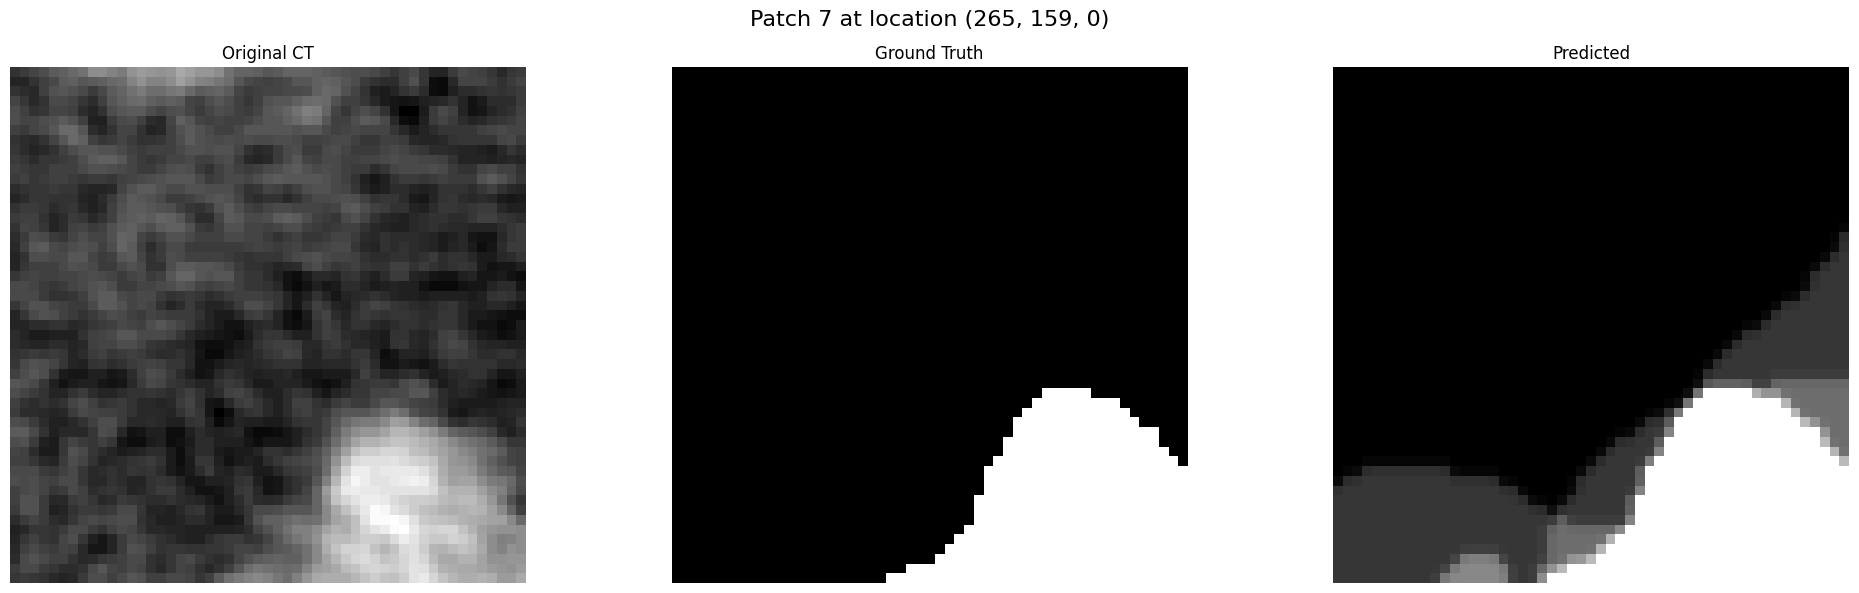

Patch 7 shape - CT: (53, 53, 32), GT: (53, 53, 32)


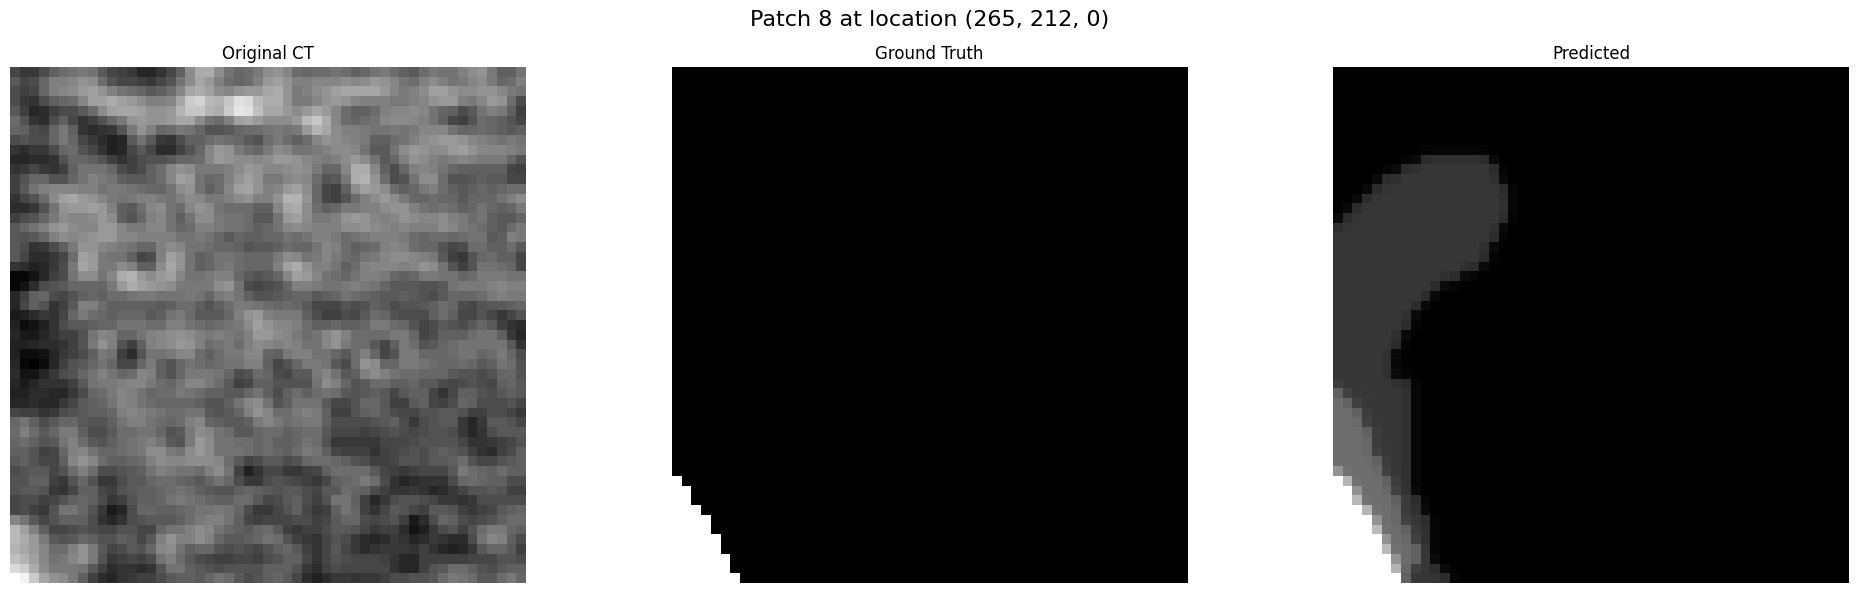

Patch 8 shape - CT: (53, 53, 32), GT: (53, 53, 32)


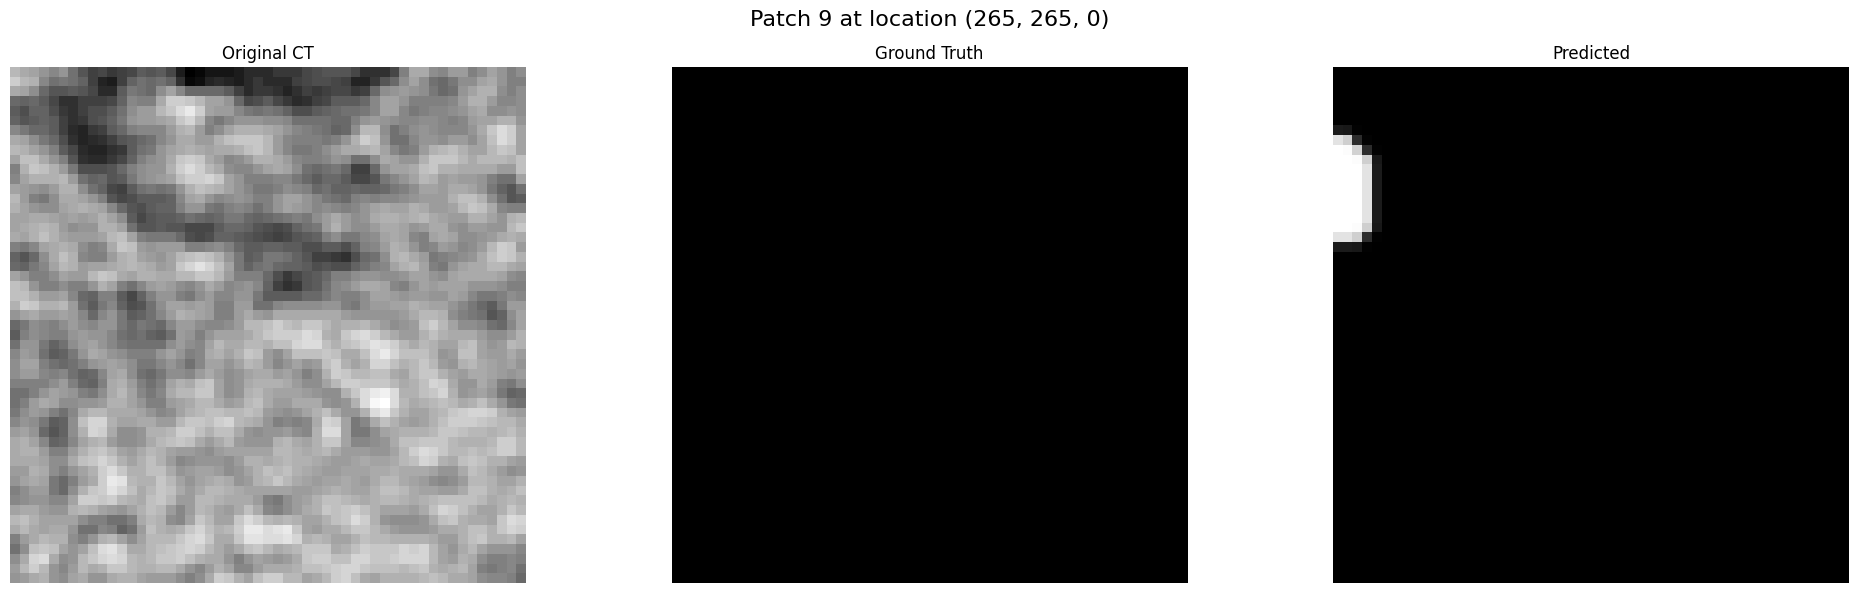

Patch 9 shape - CT: (53, 53, 32), GT: (53, 53, 32)


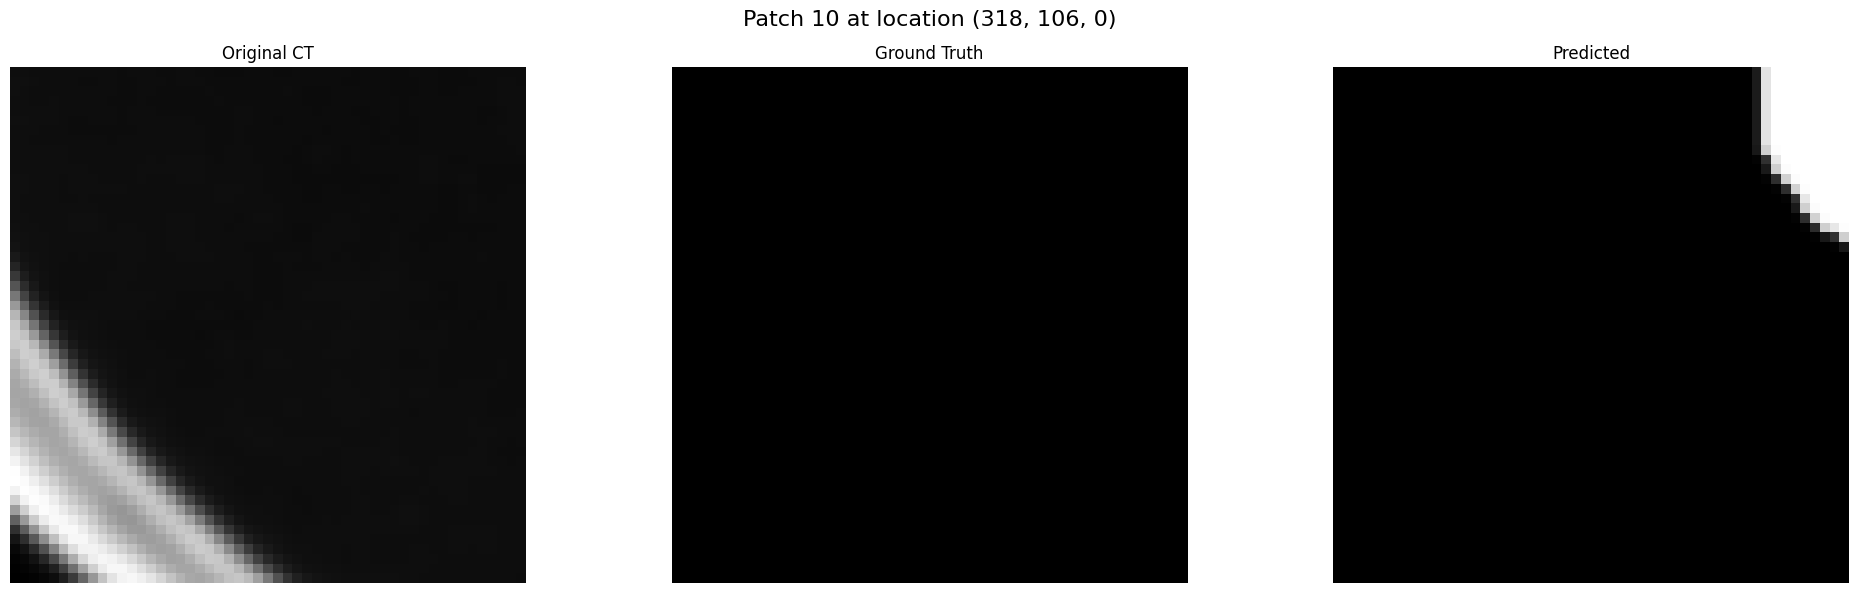

Patch 10 shape - CT: (53, 53, 32), GT: (53, 53, 32)


Patch 11 shape - CT: (53, 53, 32), GT: (53, 53, 32)


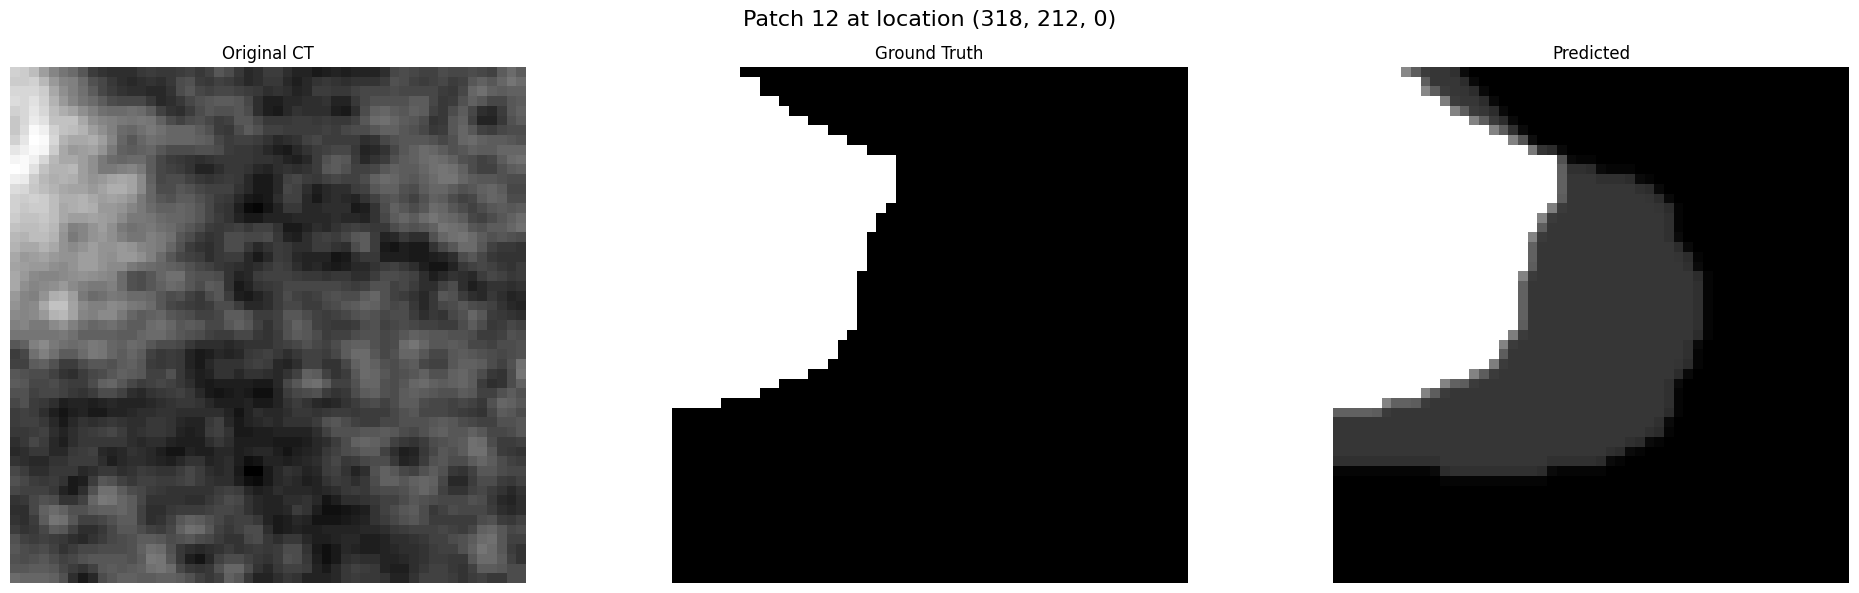

Patch 12 shape - CT: (53, 53, 32), GT: (53, 53, 32)


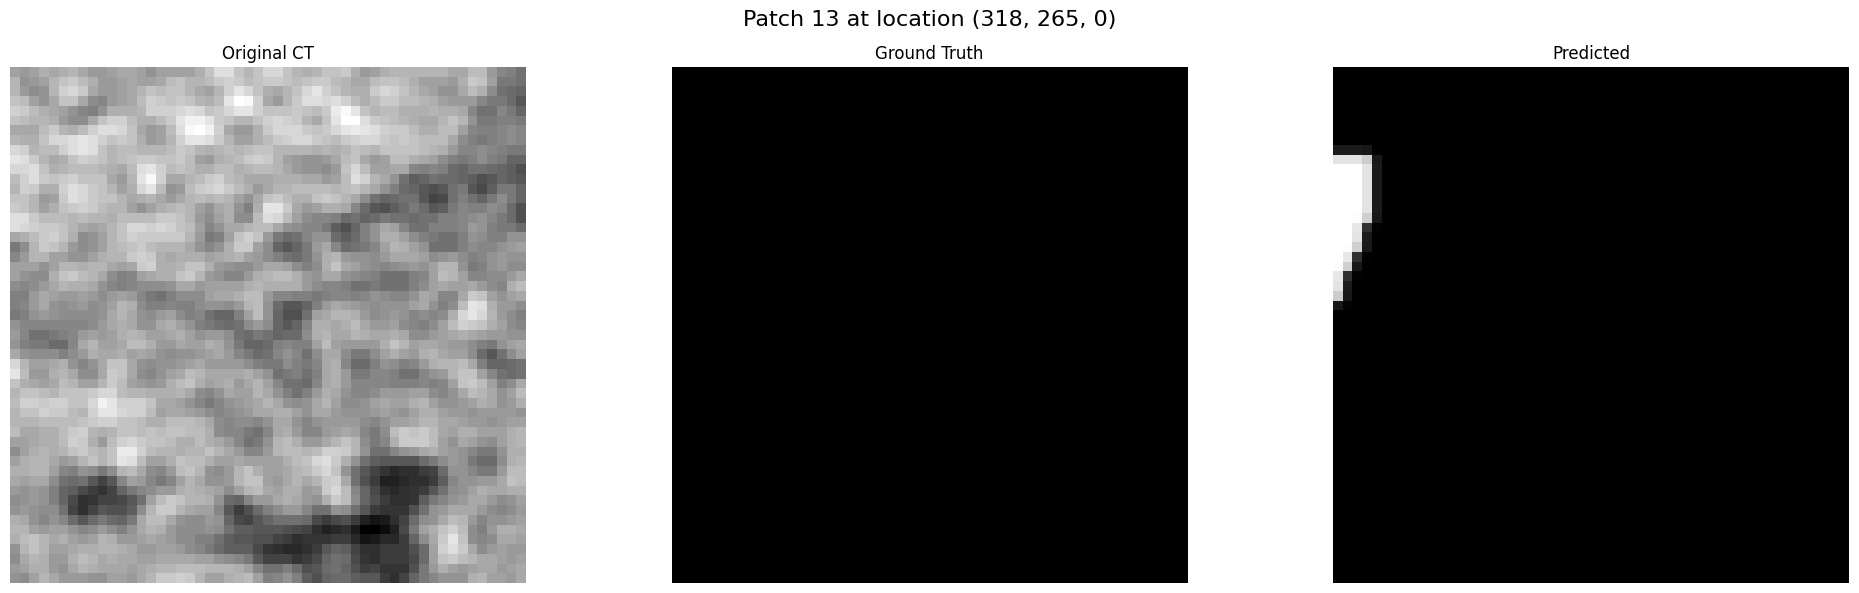

Patch 13 shape - CT: (53, 53, 32), GT: (53, 53, 32)


Patch 14 shape - CT: (53, 53, 32), GT: (53, 53, 32)


In [35]:
def get_matching_ground_truth(test_filename, ground_truth_directory):
    """Find matching ground truth file for a given test file"""
    # Remove file extension from test filename
    base_name = test_filename.replace('.nii', '')
    
    # List all ground truth files
    gt_files = os.listdir(ground_truth_directory)
    
    # Look for matching file (ignoring ._ prefix and considering .nii.gz extension)
    for gt_file in gt_files:
        # Remove ._ prefix and .nii.gz extension
        gt_base = gt_file.replace('._', '').replace('.nii.gz', '')
        if base_name in gt_base or gt_base in base_name:
            return os.path.join(ground_truth_directory, gt_file)
    
    return None

def test_samples(model, test_directory, ground_truth_directory=None, n_samples=1):
    """Test function with improved file matching"""
    # Verify directories exist
    if not os.path.exists(test_directory):
        raise FileNotFoundError(f"Test directory not found: {test_directory}")
    
    if ground_truth_directory and not os.path.exists(ground_truth_directory):
        print(f"Warning: Ground truth directory not found: {ground_truth_directory}")
        ground_truth_directory = None
    
    # List and verify test files
    test_files = [f for f in os.listdir(test_directory) if f.endswith('.nii')]
    if not test_files:
        raise ValueError(f"No .nii files found in {test_directory}")

    
    # Get random samples
    test_samples = np.random.choice(test_files, min(n_samples, len(test_files)), replace=False)
    
    # Process each test sample
    for sample in test_samples:
        print(f"\nProcessing test sample: {sample}")
        
        try:
            # Load and preprocess test sample
            ct_path = os.path.join(test_directory, sample)
            input_volume, affine = load_and_preprocess_test_sample(ct_path)

            predictions = predict_volume(model, input_volume)
            
            # Find matching ground truth file
            gt_path = None
            if ground_truth_directory:
                gt_path = get_matching_ground_truth(sample, ground_truth_directory)

            visualize_results(input_volume, predictions, gt_path)
            
        except Exception as e:
            print(f"Error processing {sample}: {e}")
            continue

# Main execution
if __name__ == "__main__":
    # Load model and weights
    model = DeepMedic(input_shape=(53, 53, 53, 2), num_classes=2)
    model.load_weights('/kaggle/working/best_model.weights.h5')
    
    # Define directories
    test_directory = '/kaggle/input/testdata/FirstStage_test/FirstStage_test'
    ground_truth_directory = '/kaggle/input/testing/FirstStage_test'
    plt.subplot(1, 3, 1)
    plt.imshow(ct_image[:, :, slice_index], cmap="gray")
    plt.title(f"Subdural Window ({title})")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth[:, :, slice_index], cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(softened_gt[:, :, slice_index], cmap="gray")
    plt.title("Predicted")
    plt.axis("off")
    
    plt.show()

    
    # Run testing
    test_samples(model, test_directory, ground_truth_directory)